In [175]:
library(ggplot2)
library(igraph)
library(dplyr)

## Functions and global parameters

In [28]:
color_map <- colorRampPalette(c("darkblue", "white"))

In [129]:
## Some functions  ##

# Initialize the node features given the graph, F, q, and mode
initialize_features <- function(g, F, q, mode) {
  # Generate the features
  if (mode == "pois") {
    features <- lapply(1:vcount(g), function(x) rpois(F, q))
  } else if (mode == "unif") {
    features <- lapply(1:vcount(g), function(x) sample(1:q, F, replace = TRUE))
  }
  
  # Attach the feature to each node
  V(g)$features <- features

  return(g)
}


# Compute the cultural similarity (feature overlap) between two nodes
cultural_similarity <- function(g, i, j) {
  sum(V(g)[[i]]$features == V(g)[[j]]$features)
}


# Get the indices of the different features between two nodes
cultural_differences <- function(g, i, j) {
  which(V(g)[[i]]$features != V(g)[[j]]$features)
}


# Compute the cultural similarity between all pairs of nodes
edge_similarities <- function(g) {
  sapply(E(g), function(x) cultural_similarity(g, ends(g, x)[1], ends(g, x)[2]))
}


# Single step of the dynamical model
single_step <- function(g) {
  # Randomly select an edge
  random_edge <- sample(E(g), 1)

  # Get the nodes
  node_i <- ends(g, random_edge)[1]
  node_j <- ends(g, random_edge)[2]

  # Compute the cultural similarity
  cs <- cultural_similarity(g, node_i, node_j)

  # Compute the probability of interaction
  p <- cs / F

  # Interaction
  if (runif(1) < p && p < 1) {
    diff <- cultural_differences(g, node_i, node_j)
    feature_to_change <- sample(diff, 1)
    V(g)[[node_j]]$features[feature_to_change] <- V(g)[[node_i]]$features[feature_to_change]
  }

  return(g)
}


# Find the cultural domainss
get_cultural_domains <- function(g) {
  # Get all unique feature sets
  unique_features <- unique(V(g)$features)

  sizes <- c()

  # Iterate over all unique feature sets
  for (f in unique_features) {
    # Get the nodes with the feature set
    nodes <- sapply(V(g)$features, function(x) identical(x, f))

    # Get the subgraph with the nodes
    subgraph <- induced_subgraph(g, nodes)

    # Find connected components in the subgraph and the LCC
    components <- components(subgraph)
  
    # Get the size of the LCC and update s_max
    sizes <- c(sizes, components$csize)
  }

  return(sizes)
}


# Find the largest cultural domain
get_s_max <- function(g) {
  sizes <- get_cultural_domains(g)
  return(max(sizes))
}


# Find the number of active bonds
get_n_active_bonds <- function(g, F) {
  es <- edge_similarities(g)
  active_bounds <- es[(es < F) & (es > 0)]
  return(length(active_bounds))
}

## Single shot dynamics

In [165]:
# Create the (lattice) graph
L <- 10
d <- 2
g <- make_lattice(length = L, dim = d)

In [166]:
# Hyperparameters
F <- 10 # Number of features
q <- 10 # Disorder parameter
mode <- "pois"

g <- initialize_features(g, F, q, mode)

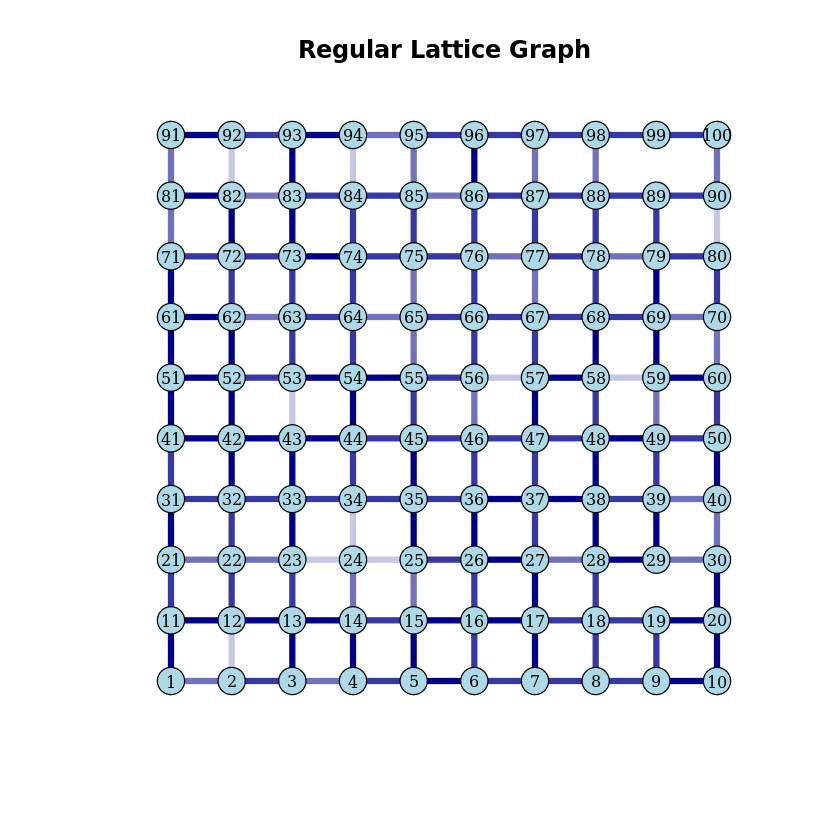

In [167]:
E(g)$similarity <- edge_similarities(g)

edge_colors <- color_map(F)[cut(E(g)$similarity, breaks=F)]

plot(g, 
     layout=layout_on_grid(g),  # Use lattice layout for proper grid representation
     main="Regular Lattice Graph",  # Title of the plot
     vertex.size=10,  # Size of the vertices
     vertex.label.cex=0.8,  # Font size of vertex labels
     edge.color=edge_colors,  # Color of the edges
     edge.width=5,  # Size of the edges
     vertex.color="lightblue",  # Color of the vertices
     vertex.frame.color="black",  # Border color of the vertices
     vertex.label.color="black"  # Color of the vertex labels
)

In [127]:
## Dynamics ##
for(i in 1:10000) {
  g <- single_step(g)
}

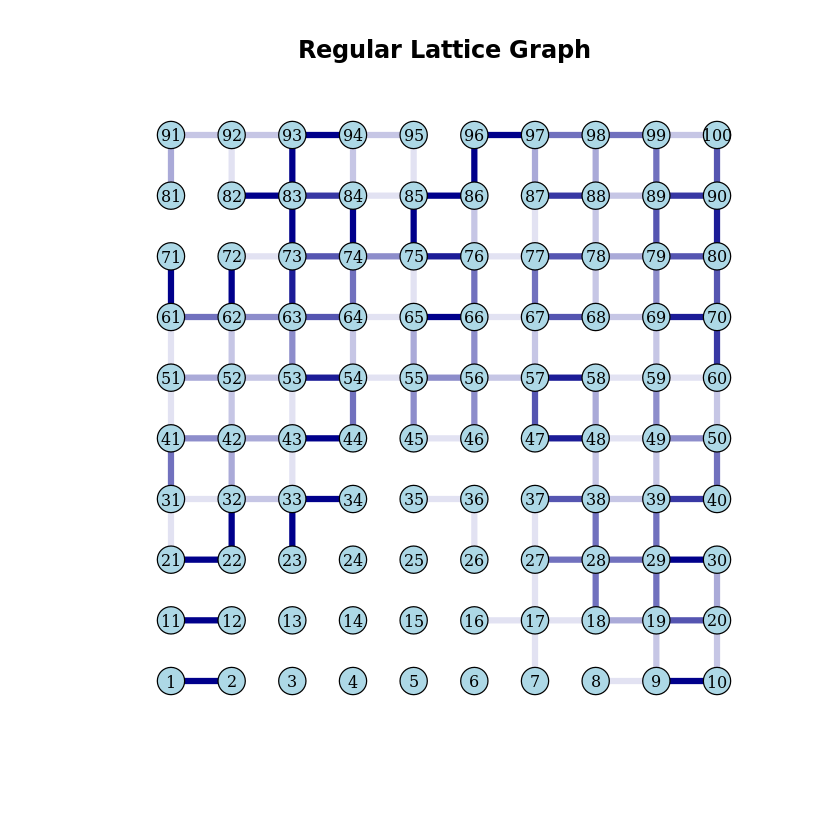

In [128]:
E(g)$similarity <- edge_similarities(g)

edge_colors <- color_map(F)[cut(E(g)$similarity, breaks=F)]

plot(g, 
     layout=layout_on_grid(g),  # Use lattice layout for proper grid representation
     main="Regular Lattice Graph",  # Title of the plot
     vertex.size=10,  # Size of the vertices
     vertex.label.cex=0.8,  # Font size of vertex labels
     edge.color=edge_colors,  # Color of the edges
     edge.width=5,  # Size of the edges
     vertex.color="lightblue",  # Color of the vertices
     vertex.frame.color="black",  # Border color of the vertices
     vertex.label.color="black"  # Color of the vertex labels
)

## Analysis

In [282]:
L <- 10
F <- 10


n_edges <- ecount(g)

q_list <- c(1, 100, 200, 230, 250, 300, 400, 500, 1000)
q_list <- c(1, 100)
max_iterations <- 1e2
log_scale <- unique(round(10^(seq(log(1), log(max_iterations), length.out = 100))))

res <- data.frame()

# Loop over the different values of q
pb <- txtProgressBar(min = 0, max = length(q_list), style = 3)
for(k in 1:length(q_list)){
  q <- q_list[k]
  
  # Repeat the simulation 10 times
  for(mc in 1:10){

    # Create and initialize the graph
    g <- make_lattice(length = L, dim = 2)
    g <- initialize_features(g, F, q, mode)
    
    # Iterate the dynamics
    for(j in 1:max_iterations){
      g <- single_step(g)
      
      # Save the results
      if(j %in% log_scale){
        s_max <- get_s_max(g)
        n_active_bonds <- get_n_active_bonds(g, F)
        density <- n_active_bonds / n_edges
        
        res <- rbind(res,
          data.frame(mc=mc, q=q, s_max=s_max, n_density=density, iteration=j))
        
        # results <- rbind(results,    
        # data.frame(q=q, s_max=s_max, n_density=n_active_bonds / n_edges, iteration=j))
      }
    }
  }
  
  setTxtProgressBar(pb, q)
}

close(pb)


  |                                                                      |   0%

  |===================================                                   |  50%


In [283]:
res

mc,q,s_max,n_density,iteration
<int>,<dbl>,<dbl>,<dbl>,<int>
1,1,1,0.9722222,1
1,1,1,0.9722222,2
1,1,1,0.9722222,3
1,1,1,0.9722222,4
1,1,1,0.9722222,5
1,1,1,0.9722222,6
1,1,1,0.9666667,7
1,1,1,0.9666667,8
1,1,1,0.9666667,9


In [284]:
# Summarize the Monte Carlo simulations
df <- res |>
  group_by(q, iteration) |>
  summarize(
    s_avg=mean(s_max), s_sd=sd(s_max), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )

tail(df)

q,iteration,s_avg,s_sd,n_avg,n_sd
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
100,59,1,0,0.2488889,0.04063961
100,65,1,0,0.2488889,0.04063961
100,73,1,0,0.2488889,0.04063961
100,81,1,0,0.2494444,0.04103012
100,90,1,0,0.2494444,0.04103012
100,100,1,0,0.2500000,0.04014719


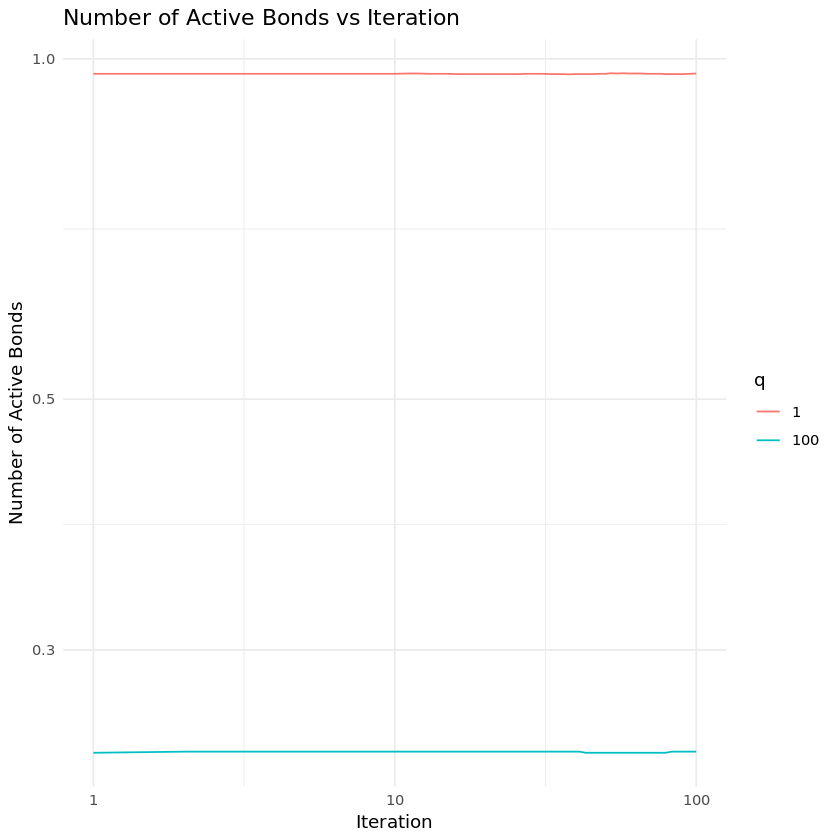

In [278]:
# Plot number of active bonds vs iteration per each q
ggplot(df, aes(x=iteration, y=n_avg, color=factor(q))) +
  geom_line() +
  scale_x_log10() +
  scale_y_log10() +
  labs(title="Number of Active Bonds vs Iteration", x="Iteration", y="Number of Active Bonds", color="q") +
  theme_minimal()


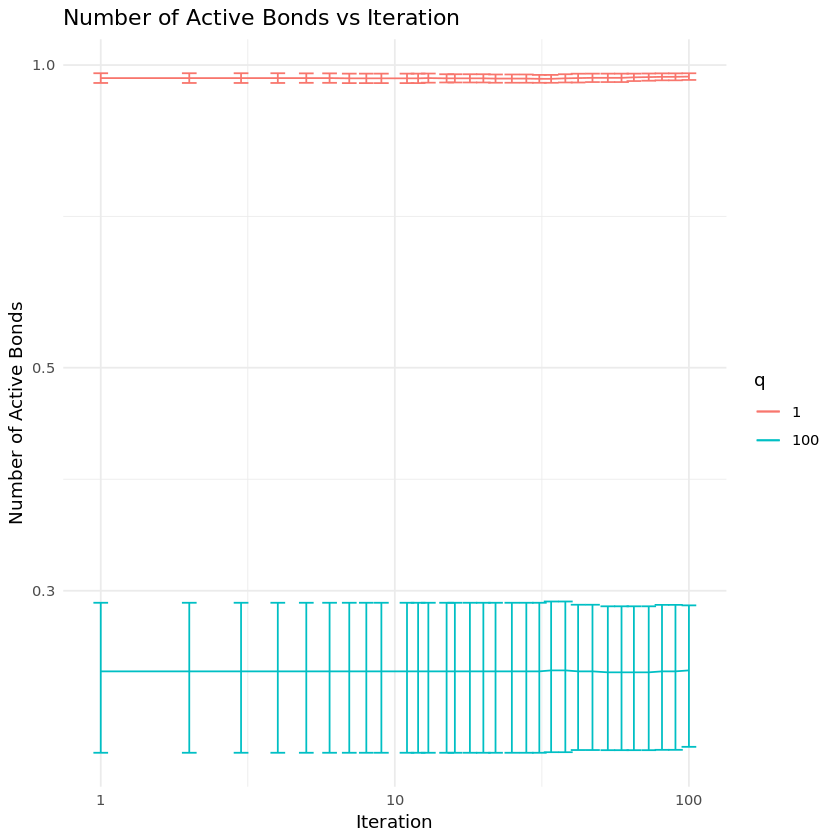

In [287]:
ggplot(df, aes(x = iteration, y = n_avg, color = factor(q))) +
  geom_line() +  # Line plot for the mean values
  geom_errorbar(aes(ymin = n_avg - n_sd, ymax = n_avg + n_sd), width = 0.05) +  # Error bars
  scale_x_log10() +  # Log scale for x-axis
  scale_y_log10() +  # Log scale for y-axis
  labs(
    title = "Number of Active Bonds vs Iteration",
    x = "Iteration",
    y = "Number of Active Bonds",
    color = "q"
  ) +
  theme_minimal()